In [1]:
import pandas as pd
import MyLib.nlp as nlp
import MyLib.HTML_prep as HTML_prep
import MyLib.analysis as analysis 
import MyLib.hype as hype 
from ipywidgets import interactive, interact

%load_ext autoreload
%autoreload 2

# 1. Import Files & group by date


In [54]:
freq="M"
#df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")

df=pd.read_json("2023-07-12_ChatGPT_Sentences_NLP-Out.json")
print("total:", len(df))

df_publ=df.drop_duplicates(subset="FileKey")[["date","FileKey"]]
df_publ=df_publ.set_index("date").groupby(pd.Grouper(freq=freq)).count()
df_publ.columns=["publications"]
df_publ.tail()

total: 10607


,publications
date,
2023-03-31,37
2023-04-30,45
2023-05-31,52
2023-06-30,18
2023-07-31,7


In [57]:
### finding a specific row by the text (to check the process of the NLP)

x=[i for i in df["sentences"].to_list() if str(i)[:7]=="Daardoor"[:7]]
df[df["sentences"].isin(x)]

,Uni,FileKey,url,file,date,Title,h1,h2,h3,text,...,paragraph_sum,LEN,text_clean,letters_count,word_count,language,source_language,pure_text,Lemmata,NoStopwords
9294,Delft University,QX27XTY5,https://www.tudelft.nl/2023/tu-delft/de-link-t...,C:\Users\mr\Zotero\storage\QX27XTY5\de-link-tu...,2023-05-24,De link tussen kunstmatige intelligentie (AI) ...,[],[Meer over AI aan de TU Delft],"[\n Data, algoritmes, machine learning, deep l...",[De link tussen kunstmatige intelligentie (AI)...,...,13607,10,"As a result, everyone can see how big the revo...",62,10,en,nl,as a result everyone can see how big the revol...,"[as, a, result, everyone, can, see, how, big, ...","[result, big, revolution]"
9330,Delft University,QX27XTY5,https://www.tudelft.nl/2023/tu-delft/de-link-t...,C:\Users\mr\Zotero\storage\QX27XTY5\de-link-tu...,2023-05-24,De link tussen kunstmatige intelligentie (AI) ...,[],[Meer over AI aan de TU Delft],"[\n Data, algoritmes, machine learning, deep l...",[De link tussen kunstmatige intelligentie (AI)...,...,13607,4,his speeds up the change process.,39,4,en,nl,his speeds up the change process,"[his, speed, up, the, change, process]","[speed, change, process]"


In [55]:
column="sentences"
df=df.explode(column).reset_index(drop=True)
df=df.drop_duplicates(column)
len(df)

10607

In [58]:
df.head()

,Uni,FileKey,url,file,date,Title,h1,h2,h3,text,...,paragraph_sum,LEN,text_clean,letters_count,word_count,language,source_language,pure_text,Lemmata,NoStopwords
0,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,C:\Users\mr\Zotero\storage\QJ4WZUBB\research-p...,2023-01-01,Research projects - Communication Science,[],[],[],"[Research projects - Communication Science, . ...",...,1700,5,esearch projects - Communication Science,40,5,en,en,esearch projects communication science,"[esearch, project, communication, science]","[esearch, project, communication, science]"
1,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,C:\Users\mr\Zotero\storage\QJ4WZUBB\research-p...,2023-01-01,Research projects - Communication Science,[],[],[],"[Research projects - Communication Science, . ...",...,1700,8,his website uses functional and non-privacy in...,61,8,en,en,his website uses functional and nonprivacy inv...,"[his, website, use, functional, and, nonprivac...","[website, use, functional, nonprivacy, invade,..."
2,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,C:\Users\mr\Zotero\storage\QJ4WZUBB\research-p...,2023-01-01,Research projects - Communication Science,[],[],[],"[Research projects - Communication Science, . ...",...,1700,11,Do you also accept the placement of other cook...,72,11,en,en,do you also accept the placement of other cook...,"[do, you, also, accept, the, placement, of, ot...","[accept, placement, cookie, typesmore, informa..."
3,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,C:\Users\mr\Zotero\storage\QJ4WZUBB\research-p...,2023-01-01,Research projects - Communication Science,[],[],[],"[Research projects - Communication Science, . ...",...,1700,2,Staff projects:.,16,2,en,en,staff projects,"[staff, project]","[staff, project]"
4,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,C:\Users\mr\Zotero\storage\QJ4WZUBB\research-p...,2023-01-01,Research projects - Communication Science,[],[],[],"[Research projects - Communication Science, . ...",...,1700,2,Information Explosion.,22,2,en,en,information explosion,"[information, explosion]","[information, explosion]"


# 2. Most common words

In [110]:
# ChatGPT_Terms="ChatGPT, GPT3, GPT4, OpenAI, AI, LLM, A.I, GPT, Chatbot, technology, tool, app, Artificial Intelligence, Large Language Models"


In [59]:
df["NoStopwords_Set"]=df.NoStopwords.apply(lambda x: list(x))
Lists=df.NoStopwords_Set.to_list()


[('ai', 1532), ('chatgpt', 1059), ('student', 930), ('chatbot', 705), ('university', 648), ('research', 625), ('use', 575), ('work', 554), ('education', 523), ('learn', 464), ('model', 461), ('language', 457), ('datum', 453), ('question', 398), ('text', 394)]


<AxesSubplot: ylabel='word'>

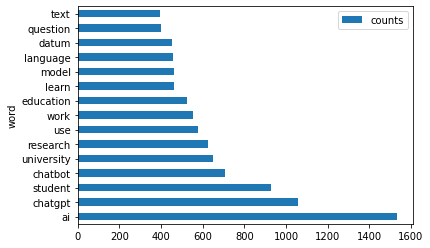

In [60]:
Lists=df.NoStopwords.to_list()

Lists=[i for i in Lists if i!=None]
Words=[item for sublist in Lists for item in sublist]

from collections import Counter
a_counter = Counter(Words)
most_common = a_counter.most_common(15)

print(most_common)#, most_common2)
pd.DataFrame.from_records(most_common,columns=["word","counts"],index="word").plot.barh()

# Finding the most hyping universities, articles, and sentences

In [61]:
# 1. Select Wordlist: here - from my hype library module (see Miller et al.)

WordLists=["predictive","imperative","subjunctive","hype_words","mod_words"] # Load from the hype module.

for wordList in WordLists:
    wordlist=hype.WordListDict[wordList]
    df[wordList+"_word"]=df.sentences.apply(hype.hype_word,keys=wordlist)
    df[wordList+"_sentence"]=df.sentences.apply(hype.hype_sentence,keys=wordlist)
    df[wordList+"_n"]=df[wordList+"_word"].apply(lambda x: len(x) if isinstance(x,list) else 0)
    
    print(f"\n ---> {wordList} <--- \n")
    
    example=df.sort_values(wordList+"_n", ascending=False).head()
    example[[wordList+"_word",wordList+"_n"]]
    
    for i in example[wordList+"_sentence"]:
        print(i)


    

df.head()

mod_words=df[df['mod_words_n']>0]




 ---> predictive <--- 

['Please note, however, that we have paid to develop and deliver this session together with the trainers, so if you sign up but cannot attend, we would greatly appreciate it if you could give us at least 4 days’ notice so that we can advertise your spot to others who may be interested.']
["Of course, you are also free to shape this outside this meeting.During the meeting, you will be asked to share briefly how you are already working on Artificial Intelligence in education, and/or how you would like to contribute to a project.If you would like to contribute as a consortium member or leader, but cannot attend the meeting, you may send a message to cat@uu.nl stating 'USO- Artificial Intelligence in Education', indicating how you would like to contribute to a project (as a consortium member, or leader; what activities would you like to contribute in the project?)."]
['Maybe it could add a watermark in the text, so you can always see what the source of the text is.

C:\Users\mr\AppData\Local\Temp\ipykernel_15828\2023392683.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  timerows[["publications","hype_words","mod_words"]][timerows.index>pd.datetime(2022,6,1)].plot()
C:\Users\mr\AppData\Local\Temp\ipykernel_15828\2023392683.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  timerows[["publications","predictive","imperative","subjunctive"]][timerows.index>pd.datetime(2022,6,1)].plot()


<AxesSubplot: xlabel='date'>

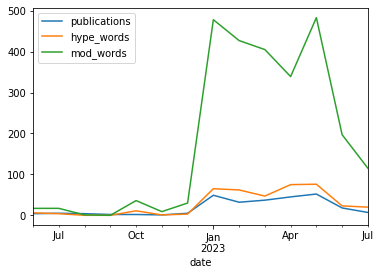

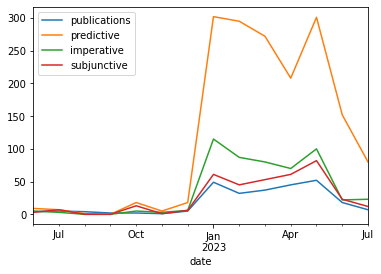

In [62]:
## Generate Timerows

freq="M"

hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))

timerows=df_publ
for l in WordLists:
    timerows[l]=hype_time[l+"_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
    
timerows[["publications","hype_words","mod_words"]][timerows.index>pd.datetime(2022,6,1)].plot()
timerows[["publications","predictive","imperative","subjunctive"]][timerows.index>pd.datetime(2022,6,1)].plot()

# Named entity recognition of hype sentences

In [31]:
df_test=df[df.language=="en"].explode(column="hype_sentence")[:20]

def NER(RAW_text):
    import spacy
    from spacy import displacy

    NER = spacy.load("en_core_web_sm")
    text=NER(RAW_text)

    text=[(word.text, word.label_) for word in text.ents]
    
    return text


df_test["NER"]=df_test.AI_sentences.apply(NER)
df_test["NER"]

2591                                                   []
2358    [(centre?One, CARDINAL), (the EUR Smart Campus...
2659    [(One, CARDINAL), (three, CARDINAL), (just fou...
50                                                     []
467                                           [(AI, ORG)]
2785                                                   []
2374                    [(recent years, DATE), (AI, ORG)]
230                                                    []
1447                                                   []
4153                                  [(Vincent, PERSON)]
2376                    [(AI, ORG), (AI, ORG), (AI, ORG)]
4177                                  [(Vincent, PERSON)]
5591                                                   []
3163                    [(ChatLab, ORG), (two, CARDINAL)]
2683    [(EUR, ORG), (AI, ORG), (ERS Business Developm...
3127                    [(ChatLab, ORG), (two, CARDINAL)]
2409                    [(recent years, DATE), (AI, ORG)]
3474    [(Chat

In [32]:
pd.set_option('display.max_colwidth', None)
[i for i in df_test["NER"]]

[[],
 [('centre?One', 'CARDINAL'),
  ('the EUR Smart Campus Project', 'ORG'),
  ('Opens', 'ORG')],
 [('One', 'CARDINAL'),
  ('three', 'CARDINAL'),
  ('just four days', 'DATE'),
  ('5', 'CARDINAL'),
  ('European', 'NORP'),
  ('EUR', 'ORG'),
  ('TU Delft', 'ORG'),
  ('Zuid', 'GPE'),
  ('Holland', 'GPE'),
  ('NWO', 'ORG'),
  ('EUR', 'ORG'),
  ('first', 'ORDINAL'),
  ('2', 'CARDINAL')],
 [],
 [('AI', 'ORG')],
 [],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [],
 [],
 [('Vincent', 'PERSON')],
 [('AI', 'ORG'), ('AI', 'ORG'), ('AI', 'ORG')],
 [('Vincent', 'PERSON')],
 [],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('EUR', 'ORG'),
  ('AI', 'ORG'),
  ('ERS Business Development & Knowledge Transfer Team', 'ORG')],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [('ChatGPT', 'ORG'), ('Google', 'ORG'), ('one', 'CARDINAL'), ('AI', 'ORG')],
 [('the Centre of Expertise in Learning & Teaching', 'ORG'),
  ('one', 'CARDINAL'),
  ('AI', 'ORG'),
  ('AI', 'ORG')

# Hype-word & Mod-word statistics per university

In [63]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "mod_words":df.groupby("Uni").sum()["mod_words_n"]})

Counts["mean mod-words"]=Counts["mod_words"]/Counts["sentences"]

Counts.sort_values("mean mod-words", ascending=False)

,publications,sentences,mod_words,mean mod-words
Uni,,,,
Rotterdam University,31,529,274,0.517958
Utrecht University,36,1170,539,0.460684
University of Groningen,17,458,180,0.393013
Vrije Universiteit Amsterdam,33,1057,395,0.373699
Maastricht Univerisity,28,985,363,0.368528
University of Twente,32,379,134,0.353562
Tilburg University,15,584,185,0.316781
Wageningen University,12,285,90,0.315789
Leiden University,46,864,241,0.278935


In [70]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "hype_words":df.groupby("Uni").sum()["hype_words_n"]})

Counts["mean hype_words"]=Counts["hype_words"]/Counts["sentences"]
Counts.sort_values("mean hype_words", ascending=False)

,publications,sentences,hype_words,mean hype_words
Uni,,,,
Rotterdam University,31,529,60,0.113422
University of Twente,32,379,35,0.092348
Vrije Universiteit Amsterdam,33,1057,82,0.077578
Maastricht Univerisity,28,985,70,0.071066
Wageningen University,12,285,19,0.066667
Utrecht University,36,1170,65,0.055556
University of Amsterdam,28,969,53,0.054696
Tilburg University,15,584,28,0.047945
University of Groningen,17,458,21,0.045852


# Use of words over time

In [88]:
from collections import Counter


keyWords="chatgpt,education,chatbot,university,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"
keyWords="education,chatbot,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"

keyWords=keyWords.split(",")
print(keyWords)

group=df.set_index("date").groupby(pd.Grouper(freq='M'))["NoStopwords"].sum()

Wordyear={}
Wordyear_exact={}
Wordyear_only={}
for i, row in group.iteritems():
    
    #print(i,row)
    if type(row)==list:
        
        ## filter ROW for interesting key-words:
        row=[i for i in row if i in keyWords]
        
        c=Counter(row).most_common(5)
        
        c_exact=[(i[0],i[1]/len(group)) for i in c]

        c=[(i[0],str(round(i[1]/len(group)*100,2))+"%") for i in c]
        c_only=[i[0] for i in c]


        Wordyear[str(i)]=c
        Wordyear_exact[str(i)]=c_exact
        Wordyear_only[str(i)]=c_only
        
        
        
    #print(c,"\n")
    
CountDF=pd.DataFrame.from_dict(Wordyear, orient='index').T


CountDF.T[CountDF.T.index>"2022-10-01"]

['education', 'chatbot', 'create', 'write', 'produce', 'answer', 'tool', 'human', 'skill', 'knowledge', 'bias', 'assignment', 'intelligence', 'artificial', 'test', 'evaluate', 'assessment', 'plagiarism']


,0,1,2,3,4
2022-10-31 00:00:00,"(knowledge, 2.37%)","(chatbot, 1.02%)","(artificial, 0.68%)","(intelligence, 0.68%)","(human, 0.34%)"
2022-11-30 00:00:00,"(chatbot, 1.69%)",None,None,None,None
2022-12-31 00:00:00,"(write, 9.49%)","(artificial, 4.75%)","(answer, 4.41%)","(intelligence, 4.07%)","(human, 3.73%)"
2023-01-31 00:00:00,"(chatbot, 30.17%)","(education, 23.05%)","(human, 18.98%)","(intelligence, 18.64%)","(write, 16.27%)"
2023-02-28 00:00:00,"(chatbot, 18.98%)","(write, 18.64%)","(human, 17.63%)","(education, 16.27%)","(tool, 12.88%)"
2023-03-31 00:00:00,"(education, 28.14%)","(answer, 20.68%)","(write, 17.97%)","(chatbot, 17.29%)","(tool, 14.92%)"
2023-04-30 00:00:00,"(education, 18.64%)","(human, 14.58%)","(intelligence, 12.2%)","(artificial, 10.85%)","(create, 10.85%)"
2023-05-31 00:00:00,"(intelligence, 21.02%)","(artificial, 20.68%)","(education, 19.66%)","(tool, 16.27%)","(write, 13.9%)"
2023-06-30 00:00:00,"(education, 16.27%)","(artificial, 7.46%)","(answer, 7.12%)","(intelligence, 6.44%)","(tool, 6.44%)"
2023-07-31 00:00:00,"(intelligence, 4.41%)","(human, 4.07%)","(skill, 3.73%)","(artificial, 3.73%)","(knowledge, 2.03%)"


In [89]:
CountDF=pd.DataFrame.from_dict(Wordyear_only, orient='index').T
CountDF.T[CountDF.T.index>"2022-10-01"]

,0,1,2,3,4
2022-10-31 00:00:00,knowledge,chatbot,artificial,intelligence,human
2022-11-30 00:00:00,chatbot,None,None,None,None
2022-12-31 00:00:00,write,artificial,answer,intelligence,human
2023-01-31 00:00:00,chatbot,education,human,intelligence,write
2023-02-28 00:00:00,chatbot,write,human,education,tool
2023-03-31 00:00:00,education,answer,write,chatbot,tool
2023-04-30 00:00:00,education,human,intelligence,artificial,create
2023-05-31 00:00:00,intelligence,artificial,education,tool,write
2023-06-30 00:00:00,education,artificial,answer,intelligence,tool
2023-07-31 00:00:00,intelligence,human,skill,artificial,knowledge


In [54]:
#df=df.drop_duplicates("text_clean")

# Words in context & Word-Graph analysis

In [92]:
#This cell allows to read the words before and after a search_word. You can change the searchword & the size of the context.
@interact(search_word="education",words_before=(0,10),words_after=(0,10))
def text_context(column=["text_clean","pure_text","NoStopwords","sentences"],search_word="education",words_before=1,words_after=1):
    df[column].dropna().apply(analysis.Keyword_context,search_word=search_word.lower(),context=(words_before,words_after))


interactive(children=(Dropdown(description='column', options=('text_clean', 'pure_text', 'NoStopwords', 'sente…

In [94]:
# WORD _GRAPH ANALYSIS

G=analysis.Word_NetworkGen(df,n=500,column="NoStopwords")
G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=True)
#G2=G
analysis.writeNetworkHTML(G2,view=False)
print("see the network: The_network.html")

[(('ai', 'ai'), 354), (('artificial', 'intelligence'), 323), (('language', 'model'), 188), (('generative', 'ai'), 143), (('ai', 'system'), 135)]
Cleaning Graph to minimum Degree 2.
Nodes count:  86
Edges count:  299
see the network: The_network.html


In [96]:
import networkx as nx
nx.write_gexf(G, "NoStopwords.gexf")

Centrality=pd.DataFrame(nx.closeness_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)

Centrality.columns=["closeness-Centrality_per_sentence"]
Centrality.head(10)

,closeness-Centrality_per_sentence
ai,0.718048
chatgpt,0.575422
research,0.563836
student,0.560078
university,0.515409
chatbot,0.512266
write,0.497110
generate,0.491296
education,0.482825
learn,0.477339


# Link Analysis 

In [108]:
import networkx as nx

df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
links=df[["url","linkUrl"]].drop_duplicates(subset="url").explode("linkUrl")

In [109]:
def domain_From_url(url):
    if isinstance(url,str):
        domain=url.replace("https://","").replace("http://","").replace("www.","").split("/")[0].lstrip(".")
        domain=domain.rsplit("@",1)[-1].rsplit("%20",1)[-1]
        if domain.count(".")>1:
            domain=".".join(domain.rsplit(".",2)[-2:])

        if "." in domain:
            return domain
    
    


links["source"]=links.url.apply(domain_From_url)
links["target"]=links.linkUrl.apply(domain_From_url).reindex()

In [110]:
links=links.dropna(subset="target").dropna(subset="source")
links=links[~links["url"].apply(lambda x: "linkedin.com" in x)]
edgelist=(zip(links["source"], links["target"]))

links[links["source"]==None]
G = nx.from_edgelist(edgelist)
nx.write_gexf(G,"Links.gexf")
Link_Centrality=pd.DataFrame(nx.closeness_centrality(G),index=[0]).T.sort_values(ascending=False, by=0)
Link_Centrality.columns=["Centrality"]
Link_Centrality.head(10)

,Centrality
openai.com,0.436815
linkedin.com,0.418636
youtube.com,0.413075
facebook.com,0.410595
rug.nl,0.391782
twitter.com,0.388666
uu.nl,0.381300
uva.nl,0.375440
ru.nl,0.369358
tudelft.nl,0.368562


In [100]:
edgelist=(zip(links["source"], links["target"]))
edges=list(edgelist)

In [101]:
from collections import Counter
pd.DataFrame(Counter(edges).most_common(15))

,0,1
0,"(vu.nl, vu.nl)",229
1,"(tudelft.nl, tudelft.nl)",188
2,"(uu.nl, uu.nl)",171
3,"(utwente.nl, utwente.nl)",155
4,"(ru.nl, ru.nl)",128
5,"(tue.nl, tue.nl)",102
6,"(universiteitleiden.nl, universiteitleiden.nl)",92
7,"(wur.nl, wur.nl)",90
8,"(maastrichtuniversity.nl, maastrichtuniversity.nl)",86
9,"(eur.nl, eur.nl)",72


In [102]:
links=df.linkUrl.to_list()
links=[list(set(l))for l in links if type(l)==list]
links=[i for s in links for i in s if i!=None]
domains=[domain_From_url(i) for s in links for i in s if i!=None]

In [103]:

from collections import Counter
a_counter = Counter(links)
most_common = a_counter.most_common(15)
most_common

[('https://www.facebook.com/vuamsterdam', 128),
 ('https://www.youvisit.com/tour/vuamsterdam', 128),
 ('https://www.instagram.com/vuamsterdam/', 128),
 ('https://twitter.com/VUamsterdam', 128),
 ('https://www.linkedin.com/school/vrije-universiteit-amsterdam/', 128),
 ('https://www.youtube.com/user/vrijeuniversiteit', 128),
 ('https://workingat.vu.nl/home', 119),
 ('https://vu.nl/en/research', 119),
 ('https://vu.nl/en/education/professionals', 119),
 ('https://studiegids.vu.nl/en', 119),
 ('https://vu.nl/en/about-vu/divisions/university-library', 119),
 ('https://www.vu.nl/en', 119),
 ('https://vu.nl/en/education', 119),
 ('https://vu.nl/en/education/bachelor', 119),
 ('https://vu.nl/en/dashboard/people', 119)]

In [104]:
links=df.linkUrl.to_list()